# R: Basic usage of `r5r`

```{admonition} Credits:

This tutorial is a direct copy from [r5r -documentation](https://ipeagit.github.io/r5r/articles/r5r.html) made by Rafael H. M. Pereira, Marcus Saraiva, Daniel Herszenhut, Carlos Kaue Braga.
```

# 1. Introduction 

**r5r** is an [R package for rapid realistic routing on multimodal transport networks](https://github.com/ipeaGIT/r5r) (walk, bike, public transport and car). It provides a simple and friendly interface to R<sup>5</sup>, a really fast and open source Java-based routing engine developed separately by [Conveyal](https://www.conveyal.com/). R<sup>5</sup> stands for [Rapid Realistic Routing on Real-world and Reimagined networks](https://github.com/conveyal/r5). More details about **r5r** can be found on the [package webpage](https://ipeagit.github.io/r5r/index.html) or on this [paper](
https://doi.org/10.32866/001c.21262).

# 2. Installation

You can install `r5r` from CRAN, or the development version from github.


In [2]:
# CRAN
#install.packages('r5r')

# github
#devtools::install_github("ipeaGIT/r5r", subdir = "r-package")

Please bear in mind that you need to have *Java SE Development Kit 11* installed on your computer to use `r5r`. No worries, you don't have to pay for it. The jdk 11 is freely available from the options below:
- [OpenJDK](https://jdk.java.net/java-se-ri/11)
- [Oracle](https://www.oracle.com/java/technologies/javase-jdk11-downloads.html)
If you don't know what version of Java you have installed on your computer, you can check it by running this on R console.

In [3]:
rJava::.jinit()
rJava::.jcall("java.lang.System", "S", "getProperty", "java.version")

[1] "11.0.1"

# 3. Usage

Before we start, we need to increase the memory available to Java. This is necessary because, by default, `R` allocates only 512MB of memory for Java processes, which is not enough for large queries using `r5r`. To increase available memory to 2GB, for example, we need to set the `java.parameters` option at the beginning of the script, as follows:


In [4]:
options(java.parameters = "-Xmx2G")

Note: It's very important to allocate enough memory before loading `r5r` or any other Java-based package, since `rJava` starts a Java Virtual Machine only once for each R session. It might be useful to restart your R session and execute the code above right after, if you notice that you haven't succeeded in your previous attempts. 

Then we can load the packages used in this vignette:

In [5]:
library(r5r)
library(sf)
library(data.table)
library(ggplot2)

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



The `r5r` package has five fundamental functions:

1. `setup_r5()` to initialize an instance of `r5r`, that also builds a routable
transport network;

2. `accessibility()` for fast computation of access to opportunities considering
a selected decay function;

3. `travel_time_matrix()` for fast computation of travel time estimates between origin/destination pairs;

4. `expanded_travel_time_matrix()` for calculating travel matrices between origin destination pairs with additional information such routes used and total time disaggregated by access, waiting, in-vehicle and transfer times.

5. `detailed_itineraries()` to get detailed information on one or multiple alternative routes between origin/destination pairs.

Most of these functions also allow users to account for monetary travel costs 
when generating travel time matrices and accessibility estimates. More info about
how to consider monetary costs can be found in [this vignette](https://ipeagit.github.io/r5r/articles/fare_calculator.html).


## 3.1 Data requirements:

To use `r5r`, you will need:
- A road network data set from OpenStreetMap in `.pbf` format (*mandatory*)
- A public transport feed in `GTFS.zip` format (optional)
- A raster file of Digital Elevation Model data in `.tif` format (optional)

Here are a few places from where you can download these data sets:

- OpenStreetMap
  - [osmextract](https://docs.ropensci.org/osmextract/) R package
  - [geofabrik](https://download.geofabrik.de/) website
  - [hot export tool](https://export.hotosm.org/) website
  - [BBBike.org](https://extract.bbbike.org/) website

- GTFS
  - [tidytransit](http://tidytransit.r-transit.org/) R package
  - [transitland](https://www.transit.land/) website
  
- Elevation
  - [elevatr](https://github.com/jhollist/elevatr) R package
  - [Nasa's SRTMGL1](https://lpdaac.usgs.gov/products/srtmgl1v003/) website
Let's have a quick look at how `r5r` works using a sample data set.



# 4. Demonstration on sample data

## Data

To illustrate the functionalities of `r5r`, the package includes a small sample data for the city of Porto Alegre (Brazil). It includes seven files:

* An OpenStreetMap network: `poa_osm.pbf`
* Two public transport feeds: `poa_eptc.zip` and `poa_trensurb.zip`
* A raster elevation data: `poa_elevation.tif`
* A `poa_hexgrid.csv` file with spatial coordinates of a regular hexagonal grid covering the sample area, which can be used as origin/destination pairs in a travel time matrix calculation.
* A `poa_points_of_interest.csv` file containing the names and spatial coordinates of 15 places within Porto Alegre
* A `fares_poa.zip` file with the fare rules of the city's public transport system.

In [6]:
data_path <- system.file("extdata/poa", package = "r5r")
list.files(data_path)

[1] "fares"                      "poa_elevation.tif"         
[3] "poa_eptc.zip"               "poa_hexgrid.csv"           
[5] "poa_osm.pbf"                "poa_points_of_interest.csv"
[7] "poa_trensurb.zip"

The points of interest data can be seen below.  In this example, we will be looking at transport alternatives between some of those places.

In [7]:
poi <- fread(file.path(data_path, "poa_points_of_interest.csv"))
head(poi)

id,lat,lon
<chr>,<dbl>,<dbl>
public_market,-30.02756,-51.22781
bus_central_station,-30.02329,-51.21886
gasometer_museum,-30.03404,-51.24095
santa_casa_hospital,-30.03043,-51.22240
townhall,-30.02800,-51.22865
piratini_palace,-30.03363,-51.23068


The data with origin destination pairs is shown below. In this example, we will be using  200 points randomly selected from this data set.


In [8]:
points <- fread(file.path(data_path, "poa_hexgrid.csv"))
# sample points
sampled_rows <-  sample(1:nrow(points), 200, replace=TRUE)
points <- points[ sampled_rows, ]
head(points)

V1,id,lon,lat,population,schools,jobs,healthcare
<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
49,89a90129e8bffff,-51.15162,-30.04053,672,0,90,0
988,89a90128103ffff,-51.21625,-30.05861,823,0,201,0
1216,89a90129bbbffff,-51.17763,-30.00641,637,1,566,0
1203,89a9012880bffff,-51.23320,-30.02665,2,0,0,0
1104,89a90129e8fffff,-51.15460,-30.03890,873,0,94,0
658,89a90128667ffff,-51.17425,-30.07329,1208,0,11,0


## 4.1 Building routable transport network with `setup_r5()`
The first step is to build the multimodal transport network used for routing in R<sup>5</sup>. This is done with the `setup_r5` function. This function does two things: (1) downloads/updates a compiled JAR file of R<sup>5</sup> and stores it locally in the `r5r` package directory for future use; and (2) combines the osm.pbf and gtfs.zip data sets to build a routable network object.


In [9]:
# Indicate the path where OSM and GTFS data are stored
r5r_core <- setup_r5(data_path = data_path)



Finished building network.dat at /home/hentenka/.conda/envs/mamba/envs/r5/lib/R/library/r5r/extdata/poa/network.dat



## 4.2 Accessibility analysis
The faster way to calculate accessibility estimates is using the `accessibility()`
function. In this example, we calculate the number of schools and health care 
facilities accessible in less than 60 minutes by public transport and walking.
More details in this vignette on [Calculating and visualizing Accessibility](https://ipeagit.github.io/r5r/articles/calculating_accessibility.html).

In [10]:
# set departure datetime input
departure_datetime <- as.POSIXct("13-05-2019 14:00:00",
                                 format = "%d-%m-%Y %H:%M:%S")
# calculate accessibility
access <- accessibility(r5r_core = r5r_core,
                        origins = points,
                        destinations = points,
                        opportunities_colnames = c("schools", "healthcare"),
                        mode = c("WALK", "TRANSIT"),
                        departure_datetime = departure_datetime,
                        decay_function = "step",
                        cutoffs = 60
                        )
head(access)

id,opportunity,percentile,cutoff,accessibility
<chr>,<chr>,<int>,<int>,<dbl>
89a90129e8bffff,schools,50,60,31
89a90129e8bffff,healthcare,50,60,17
89a90128103ffff,schools,50,60,32
89a90128103ffff,healthcare,50,60,18
89a90129bbbffff,schools,50,60,28
89a90129bbbffff,healthcare,50,60,12


## 4.3 Routing analysis
For fast routing analysis, **r5r** currently has three core functions: 
`travel_time_matrix()`, `expanded_travel_time_matrix()` and `detailed_itineraries()`.
### Fast many to many travel time matrix
The `travel_time_matrix()` function is a really simple and fast function to 
compute travel time estimates between one or multiple origin/destination pairs. 
The origin/destination input can be either a spatial `sf POINT` object, or a 
`data.frame` containing the columns `id, lon, lat`. The function also receives 
as inputs the *max walking distance*, in meters, and the *max trip duration*, in
minutes. Resulting travel times are also output in minutes.
This function also allows users to very efficiently capture the travel time 
uncertainties inside a given time window considering multiple departure times. 
[More info on this vignette](https://ipeagit.github.io/r5r/articles/time_window.html). 

In [11]:
# set inputs
mode <- c("WALK", "TRANSIT")
max_walk_time <- 30 # minutes
max_trip_duration <- 120 # minutes
departure_datetime <- as.POSIXct("13-05-2019 14:00:00",
                                 format = "%d-%m-%Y %H:%M:%S")
# calculate a travel time matrix
ttm <- travel_time_matrix(r5r_core = r5r_core,
                          origins = poi,
                          destinations = poi,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)
head(ttm)

from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
public_market,public_market,0
public_market,bus_central_station,13
public_market,gasometer_museum,10
public_market,santa_casa_hospital,15
public_market,townhall,3
public_market,piratini_palace,17


### Expanded travel time matrix with minute-by-minute estimates
For those interested in more detailed outputs, the `expanded_travel_time_matrix()` 
works very similarly with `travel_time_matrix()` but it brings much more 
information. It estimates for each origin destination pair the routes used and 
total time disaggregated by access, waiting, in-vehicle and transfer times. 
Please note this  function can be very memory intensive for large data sets.

In [12]:
# calculate a travel time matrix
ettm <- expanded_travel_time_matrix(r5r_core = r5r_core,
                          origins = poi,
                          destinations = poi,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          breakdown = TRUE,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)
head(ettm)

from_id,to_id,departure_time,draw_number,access_time,wait_time,ride_time,transfer_time,egress_time,routes,n_rides,total_time
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
public_market,public_market,14:00:00,1,0.0,0.0,0.0,0,0.0,[WALK],0,0.0
public_market,bus_central_station,14:00:00,1,2.6,2.4,1.5,0,7.4,D73,1,13.9
public_market,gasometer_museum,14:00:00,1,2.9,1.1,4.5,0,1.8,2821,1,10.3
public_market,santa_casa_hospital,14:00:00,1,0.0,0.0,0.0,0,0.0,[WALK],0,15.3
public_market,townhall,14:00:00,1,0.0,0.0,0.0,0,0.0,[WALK],0,3.5
public_market,piratini_palace,14:00:00,1,2.9,1.1,1.3,0,11.8,2821,1,17.1


### Detailed itineraries
Most routing packages only return the fastest route. A key advantage of the `detailed_itineraries()` function is that is allows for fast routing analysis 
while providing multiple alternative routes between origin destination pairs. 
The output also brings detailed information for each route alternative at the 
trip segment level, including the transport mode, waiting times, travel time and
distance of each trip segment. 
In this example below, we want to know some alternative routes between one origin/destination pair only.

In [13]:
# set inputs
origins <- poi[10,]
destinations <- poi[12,]
mode <- c("WALK", "TRANSIT")
max_walk_time <- 60 # minutes
departure_datetime <- as.POSIXct("13-05-2019 14:00:00",
                                 format = "%d-%m-%Y %H:%M:%S")
# calculate detailed itineraries
det <- detailed_itineraries(r5r_core = r5r_core,
                            origins = origins,
                            destinations = destinations,
                            mode = mode,
                            departure_datetime = departure_datetime,
                            max_walk_time = max_walk_time,
                            shortest_path = FALSE)
head(det)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,from_id,from_lat,from_lon,to_id,to_lat,to_lon,option,departure_time,total_duration,total_distance,segment,mode,segment_duration,wait,distance,route,geometry
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<LINESTRING [°]>
1,farrapos_station,-29.99772,-51.19762,praia_de_belas_shopping_center,-30.04995,-51.22875,1,14:00:54,44.4,9460,1,WALK,4.6,0.0,174,,LINESTRING (-51.1981 -29.99...
2,farrapos_station,-29.99772,-51.19762,praia_de_belas_shopping_center,-30.04995,-51.22875,1,14:00:54,44.4,9460,2,RAIL,6.6,9.5,4796,LINHA1,LINESTRING (-51.19763 -29.9...
3,farrapos_station,-29.99772,-51.19762,praia_de_belas_shopping_center,-30.04995,-51.22875,1,14:00:54,44.4,9460,3,WALK,5.7,0.0,256,,LINESTRING (-51.22827 -30.0...
4,farrapos_station,-29.99772,-51.19762,praia_de_belas_shopping_center,-30.04995,-51.22875,1,14:00:54,44.4,9460,4,BUS,10.4,4.4,4083,188,LINESTRING (-51.22926 -30.0...
5,farrapos_station,-29.99772,-51.19762,praia_de_belas_shopping_center,-30.04995,-51.22875,1,14:00:54,44.4,9460,5,WALK,3.2,0.0,151,,LINESTRING (-51.22949 -30.0...


The output is a `data.frame sf` object, so we can easily visualize the results.
#### Visualize results
**Static visualization** with `ggplot2` package: To provide a geographic context 
for the visualization of the results in `ggplot2`, you can also use the `street_network_to_sf()` function to  extract the OSM street network used in the routing.


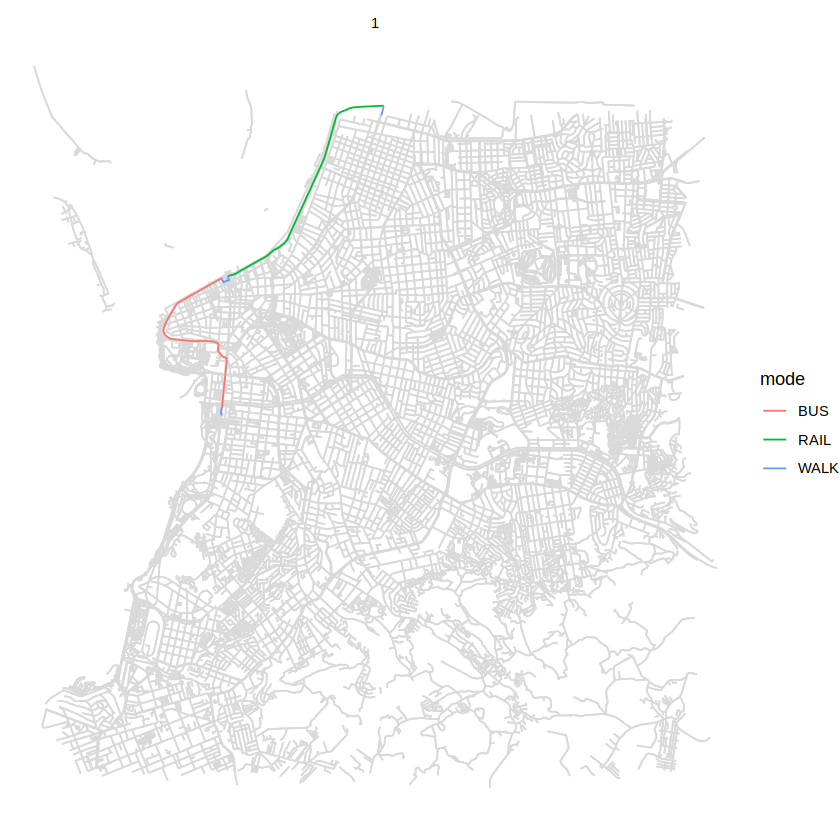

In [14]:
# extract OSM network
street_net <- street_network_to_sf(r5r_core)
# extract public transport network
transit_net <- transit_network_to_sf(r5r_core)
# plot
ggplot() +
  geom_sf(data = street_net$edges, color='gray85') +
  geom_sf(data = det, aes(color=mode)) +
  facet_wrap(.~option) + 
  theme_void()

### Cleaning up after usage
`r5r` objects are still allocated to any amount of memory previously set after they are done with their calculations. In order to remove an existing `r5r` object and reallocate the memory it had been using, we use the `stop_r5` function followed by a call to Java's garbage collector, as follows:


In [15]:
r5r::stop_r5(r5r_core)
rJava::.jgc(R.gc = TRUE)

r5r_core has been successfully stopped.



If you have any suggestions or want to report an error, please visit [the package GitHub page](https://github.com/ipeaGIT/r5r).